
# Web APIs & NLP Part 2   

_**Authors:** Zhan Yu_

## Table of Contents
- [Feature Engineering](#Feature-Engineering)  
- [Modeling](#Modeling)
    - [Baseline Model](#Baseline-Model)
    - [Naive Bayes Models](#Naive-Bayes-Models)
    - [Bagging Models](#Bagging-Models)
- [Data Visualization](#Data-Visualization)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)
- [Recommendations and limitation](#Recommendations-and-limitation)
- [References](#References)

## Loading Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer  

import regex as re
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix

/Users/zhan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Read in data
df = pd.read_csv('data/meaningful_words.csv')

In [3]:
# Drop missing values and reset index
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

## Feature Engineering  

### Stemming/Lemmentizing  
We are going to test Stemming, Lemmentizing and without Stemming/Lemmentizing for the `text` column:  

In [4]:
def stemming(text):
    
    # split into individual words.
    words = text.split()
    
    # Remove 'makeup', 'sephora'.
    stops = ['makeup', 'sephora']
    meaningful_words = [w for w in words if not w in stops]
    
    # Stemming
    p_stemmer = PorterStemmer()
    stemming = [p_stemmer.stem(i) for i in meaningful_words]
    
    # Join the words back into one string separated by space and return the result.
    return(" ".join(stemming))

For CountVectorizer with Logistic Regression:  
Training score: 0.8911708932942503  
Testing score: 0.8853102906520032   
Best parameters: {'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}  

For TfidfVectorizer with Logistic Regression:  
Training score: 0.8979096662615369  
Testing score: 0.9088766692851532  
Best parameters: {'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}  

In [5]:
def lemmatizing(text):
    
    # split into individual words.
    words = text.split()
    
    # Remove 'makeup', 'sephora'.
    stops = ['makeup', 'sephora']
    meaningful_words = [w for w in words if not w in stops]
    
    # lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmatizing = [lemmatizer.lemmatize(i) for i in meaningful_words]
    
    # Join the words back into one string separated by space and return the result.
    return(" ".join(lemmatizing))

For CountVectorizer with Logistic Regression:  
Training score: 0.8952150422322314  
Testing score: 0.8978790259230165  
Best parameters: {'vectorizer__max_features': 15000, 'vectorizer__ngram_range': (1, 2)}  
For TfidfVectorizer with Logistic Regression:  
Training score: 0.9002672495089077  
Testing score: 0.9080911233307148  
Best parameters: {'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}

In [6]:
df['text'] = df['text'].apply(lemmatizing)

## Modeling

First we are going to establish baseline model and then build Linear Regression, Naive Bayes and Bagging Models:

### Baseline Model

 
In this project we are going to build a model to predict if a post is from "Makeup" or "Sephora". So this is a classification problem and the baseline model is predicting majority class.

In [7]:
X = df['text']   # CountVectorizer requires a vector, so X is a series.
y = df['subreddit']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state = 42, 
                                                    test_size = 0.3, 
                                                    stratify = y)   

In [8]:
# Check y variable, the outcomes are not that different since we balanced our data gathering:
y.value_counts(normalize = True)

0    0.582881
1    0.417119
Name: subreddit, dtype: float64

So our baseline is 0.582881.

### Logistic Regression Models  
We are using `Pineline` to put two vectorizers `CountVectorizer` and `TfidfVectorizer`, and `LogisticRegression` model together with `GridSearchCV` to find best parameters.

In [9]:
# Logistic Regression Models with two vectorizers:
pipe_cvec_lr = Pipeline(steps = [('vectorizer', CountVectorizer()), ('model', LogisticRegression())])
pipe_tvec_lr = Pipeline(steps = [('vectorizer', TfidfVectorizer()), ('model', LogisticRegression())])

# Try to find the best parameters in max_features 5000 and 15000, 
# ngram_range is one-word only or one-word AND two-word.
pipe_params = {                             
    'vectorizer__max_features': [5000, 15000], 
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
}

# Grid search with 3 cross validation
gs_cvec_lr = GridSearchCV(pipe_cvec_lr, 
                 param_grid= pipe_params, 
                 cv = 3,
                 scoring = 'accuracy')
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, 
                 param_grid= pipe_params, 
                 cv = 3,
                 scoring = 'accuracy')

# Fit the training data in:
results_cvec_lr = gs_cvec_lr.fit(X_train, y_train)
results_tvec_lr = gs_tvec_lr.fit(X_train, y_train)

In [10]:
print(f'For CountVectorizer with Logistic Regression:\nTraining score: {results_cvec_lr.best_score_}\nTesting score: {results_cvec_lr.best_estimator_.score(X_test, y_test)}\nBest parameters: {results_cvec_lr.best_params_}')
print('==================================')
print(f'For TfidfVectorizer with Logistic Regression:\nTraining score: {results_tvec_lr.best_score_}\nTesting score: {results_tvec_lr.best_estimator_.score(X_test, y_test)}\nBest parameters: {results_tvec_lr.best_params_}')
print('==================================')

For CountVectorizer with Logistic Regression:
Training score: 0.8952150422322314
Testing score: 0.8978790259230165
Best parameters: {'vectorizer__max_features': 15000, 'vectorizer__ngram_range': (1, 2)}
For TfidfVectorizer with Logistic Regression:
Training score: 0.9002672495089077
Testing score: 0.9080911233307148
Best parameters: {'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}


This shows us the accuracy scores for the two models with best parameters. TfidfVectorizer with Logistic Regression has a high testing score but it is a little underfit.

### Naive Bayes Models  
For `CountVectorizer` we use model `MultinomialNB`; For `TfidfVectorizer` we use model `GaussianNB`.

In [11]:
X = np.array(df['text'])  # CountVectorizer requires a vector, so X is a series.
y = np.array(df['subreddit']).astype(int)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state = 42, 
                                                    test_size = 0.3, 
                                                    stratify = y)   

In [12]:
pipe_cvec_mnb = Pipeline(steps = [('vectorizer', CountVectorizer()), ('model', MultinomialNB())])


# Try to find the best parameters in max_features 5000 and 15000, 
# ngram_range is one-word only or one-word AND two-word.
pipe_params = {                             
    'vectorizer__max_features': [10000, 15000], 
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'model__alpha': [0.9, 0.95]
}

# Grid search with 3 cross validation
gs_cvec_mnb = GridSearchCV(pipe_cvec_mnb, 
                 param_grid= pipe_params, 
                 cv = 3,
                 scoring = 'accuracy')


# Fit the training data in:
results_cvec_mnb = gs_cvec_mnb.fit(X_train, y_train)

In [13]:
print(f'For CountVectorizer with Multinomial Naive Bayes:\nTraining score: {results_cvec_mnb.best_score_}\nTesting score: {results_cvec_mnb.best_estimator_.score(X_test, y_test)}\nBest parameters: {results_cvec_mnb.best_params_}')

For CountVectorizer with Multinomial Naive Bayes:
Training score: 0.9012841594236942
Testing score: 0.9018067556952082
Best parameters: {'model__alpha': 0.9, 'vectorizer__max_features': 15000, 'vectorizer__ngram_range': (1, 2)}


This shows us the accuracy scores for the two models with best parameters.

In [14]:
tvec = TfidfVectorizer(max_features = 5000, ngram_range = (1, 2))
X_train_df_tvec = pd.DataFrame(tvec.fit_transform(X_train).toarray(), 
                            columns = tvec.get_feature_names())
X_test_df_tvec = pd.DataFrame(tvec.transform(X_test).toarray(), 
                           columns = tvec.get_feature_names())

# Instantiate GaussianNB.
gnb = GaussianNB()

# Fit GaussianNB.
gnb.fit(X_train_df_tvec, y_train)

# Score GaussianNB.
print(gnb.score(X_train_df_tvec, y_train))
print(gnb.score(X_test_df_tvec, y_test))

0.9504716981132075
0.8444619010212098


This shows us the accuracy scores for traning and testing data.

### Bagging Models  
We use `BaggingClassifier`for both `CountVectorizer` and `TfidfVectorizer`.

In [15]:
cvec = CountVectorizer(max_features = 15000, ngram_range = (1, 2))
X_train_df_cvec = pd.DataFrame(cvec.fit_transform(X_train).toarray(), 
                          columns = cvec.get_feature_names())
X_test_df_cvec = pd.DataFrame(cvec.transform(X_test).toarray(), 
                         columns = cvec.get_feature_names())

# Instantiate BaggingClassifier.
bag = BaggingClassifier(random_state = 42)

# Fit BaggingClassifier.
bag.fit(X_train_df_cvec, y_train)

# Score BaggingClassifier.
print(bag.score(X_train_df_cvec, y_train))
print(bag.score(X_test_df_cvec, y_test))

0.9845013477088949
0.8766692851531814


In [16]:
# Instantiate BaggingClassifier.
bag = BaggingClassifier(random_state = 42)

# Fit BaggingClassifier.
bag.fit(X_train_df_tvec, y_train)

# Score BaggingClassifier.
print(bag.score(X_train_df_tvec, y_train))
print(bag.score(X_test_df_tvec, y_test))

0.987533692722372
0.8766692851531814


This shows us the accuracy scores for traning and testing data. There is clear evidence of overfitting here.

## Data Visualization  
We use `CountVectorizer` and `TfidfVectorizer` with two words `ngram_range=(2, 2)` which it is easier for us to see the most popular words in two subreddit.

In [17]:
cvec = CountVectorizer(ngram_range=(2, 2))
df_c = pd.DataFrame(cvec.fit_transform(df['text']).toarray(), columns = cvec.get_feature_names())
df_c['subreddit'] = df['subreddit']

In [18]:
tvec = TfidfVectorizer(ngram_range=(2, 2))
df_tvec = pd.DataFrame(tvec.fit_transform(df['text']).toarray(), columns = tvec.get_feature_names())
df_tvec['subreddit'] = df['subreddit']

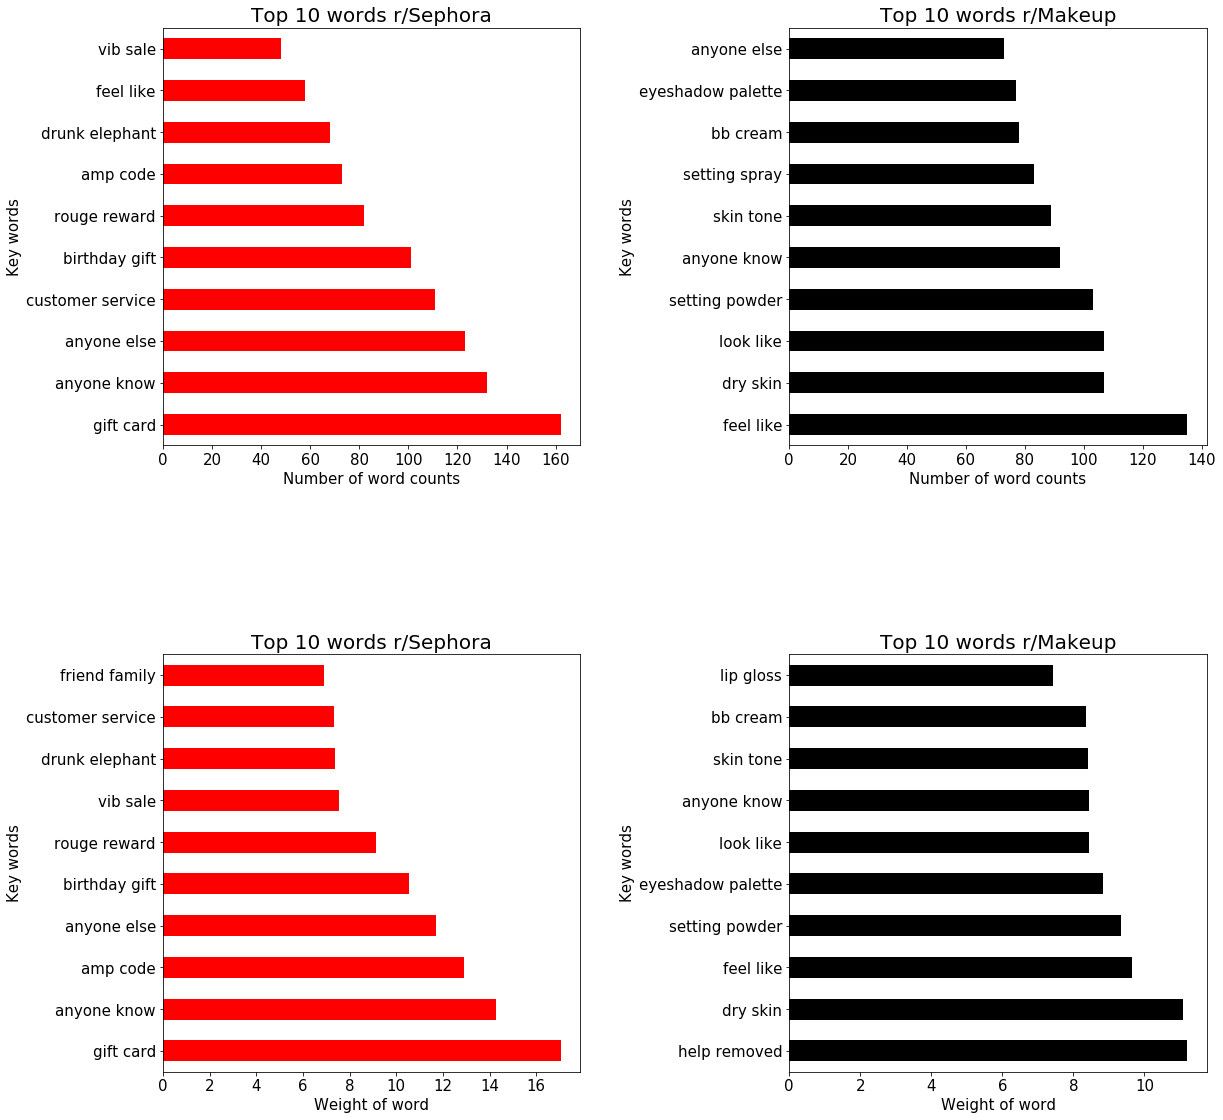

In [19]:
# Plot with various axes scales
plt.figure()

plt.subplot(221)
df_c[df_c['subreddit']==1].sum().sort_values(ascending= False)[1:11].plot(kind = 'barh', 
                                                                          color = 'red', 
                                                                          figsize = (5, 5),
                                                                        fontsize=15)
plt.title('Top 10 words r/Sephora', fontsize = 20)
plt.xlabel('Number of word counts', fontsize = 15)
plt.ylabel('Key words', fontsize = 15)

plt.subplot(222)
df_c[df_c['subreddit']==0].sum().sort_values(ascending= False).head(10).plot(kind = 'barh', 
                                                                             color = 'black', 
                                                                            figsize = (5, 5),
                                                                        fontsize=15)
plt.title('Top 10 words r/Makeup', fontsize = 20)
plt.xlabel('Number of word counts', fontsize = 15)
plt.ylabel('Key words', fontsize = 15)

plt.subplot(223)
df_tvec[df_tvec['subreddit']==1].sum().sort_values(ascending= False)[1:11].plot(kind = 'barh', 
                                                                          color = 'red', 
                                                                          figsize = (5, 5),
                                                                        fontsize=15)
plt.title('Top 10 words r/Sephora', fontsize = 20)
plt.xlabel('Weight of word', fontsize = 15)
plt.ylabel('Key words', fontsize = 15)

plt.subplot(224)
df_tvec[df_tvec['subreddit']==0].sum().sort_values(ascending= False).head(10).plot(kind = 'barh', 
                                                                             color = 'black', 
                                                                            figsize = (5, 5),
                                                                        fontsize=15)
plt.title('Top 10 words r/Makeup', fontsize = 20)
plt.xlabel('Weight of word', fontsize = 15)
plt.ylabel('Key words', fontsize = 15)

plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.subplots_adjust(top=3, bottom=0.1, left=0.10, right=3, hspace=0.5, wspace=0.5)

plt.show()

The plots showes the top 10 two-words used by two group members.

## Model Evaluation   
Let's have look at our models with the accuracy scores of traning data and testing data:

#### With our baseline score 0.582881:  

| Model | Accuracy of Traning Data | Accuracy of Testing Data |  
|---|---|---|  
| Logistic Regression with CountVectorizer | 0.8952 | 0.8979 |  
| Logistic Regression with TfidfVectorize | 0.9003 | 0.9081 |  
| MultinomialNB with CountVectorizer | 0.9013 | **0.9018** |  
| GaussianNB with TfidfVectorizer |0.9505 |0.8445 |  
| BaggingClassifierfor with CountVectorizer | 0.9845 | 0.8767 |
| BaggingClassifierfor with TfidfVectorizer | 0.9875 | 0.8767 |


Naive Bayes Models for `CountVectorizer` with `MultinomialNB` is our best model, according to the Accuracy.

#### Confusion Matrix  

Let's see what the test specificity and sensitivity of our best model MultinomialNB with CountVectorizer.

In [20]:
preds = results_cvec_mnb.predict(X_test)

# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test,             # True values.
                                  preds).ravel()      # Predicted values.

In [21]:
# The test specificity of our model:
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

# The test sensitivity:
sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Specificity: 0.9394
Sensitivity: 0.8493


So for all Makeup subreddit predictions, 93.94% we predict right; for all Sephora subreddit predictions, 84.93% we predict right.

## Conclusion

With Natural Language Processing (NLP) we could build a model which is able to identify which post are from Makeup subreddit(needed to be responded by customer service employees) and which are from Sephora subreddit (answers could simply be generated by computer) with a fairly high prediction accuracy.
The model solves the problem with our best model - Naive Bayes for CountVectorizer with MultinomialNB which can have the accuracy as 90%. 

## Recommendations and limitation  
Sephora website would use "chatbots" in order to improve their customer experience, save time and labor power and it is a better data gathering and storing method.  

**Limitations** 
- Some Ad blocker could block Chatbots.
- Texting preference (e.g. Languages): This model is only built base on English language.
- Miscommunications: Texting is sometimes not as efficient as conversations.

## References   
- [Chatbot-Wikipedia](https://en.wikipedia.org/wiki/Chatbot)  
- [Sephora-Wikipedia](https://en.wikipedia.org/wiki/Sephora)  
- [Pushshift Reddit API Documentation](https://github.com/pushshift/api)